# 7.7 卷积网络学习过程

本节为一维卷积网络反向传播过程可视化，网络结构如下：  
(1) 第一层输入层为2维向量；  
(2) 第二层为全连接网络，输出维度为3，激活函数为ReLu；   
(3) 第三层为一维卷积层，卷积核大小为2，步长为1，激活函数为ReLu；后接最大池化层，池化步长和池化尺寸均为2；  
(5) 第四层输出层为全连接层，输出维度为1，激活函数为sigmoid。  

## 7.7.1 加载数据和网络设置

In [1]:
import json
import random
import sys
import os
# 加载第三方库
import numpy as np
from sklearn import datasets # 加载数据集
from sklearn.model_selection import train_test_split # 划分数据集
from sklearn.preprocessing import StandardScaler # 标准化
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap # 构建颜色映射图
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import matplotlib.lines as lines
from matplotlib import colors

# 设置图片展示形式为网页嵌入式
%matplotlib inline
# 设置允许绘图过程中存在中文字符和负号
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

一维卷积网络结构（[点此下载](https://github.com/XuPenglei/I2DL/blob/master/source/2ndPart/Chapter5/network.py)）是由全连接神经网络结构（[点此下载](http://neuralnetworksanddeeplearning.com/chap1.html)）修改得到：

In [2]:
import network # 加载一维卷积网络结构

设置中间隐层激活激活函数（输出层激活函数为Sigmoid无法更改）：

In [3]:
# 设置随机种子，从而固定随机化过程
np.random.seed(100)
# 设置激活函数类别
activation = 'relu'

if activation=='relu':
    activation_fn = network.relu_activation
elif activation == 'sigmoid':
    activation_fn = network.sigmoid_activation
elif activation == 'tanh':
    activation_fn = network.tanh_activation
else:
    print(activation+' function not implemented')

加载训练数据和测试数据：

In [4]:
if os.path.exists("log/X.npy") and os.path.exists("log/y.npy") and os.path.exists("log/X_test.npy") and os.path.exists("log/y_test.npy"):
    X,y = np.load("log/X.npy"),np.load("log/y.npy")
    X_test,y_test = np.load("log/X_test.npy"),np.load("log/y_test.npy")
#     print("已加载保存的训练测试数据")
else:
    X, y = datasets.make_circles(n_samples=2000, factor=0.3, noise=.1,random_state=123)
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.33)
    np.save("log/X.npy", X)
    np.save("log/y.npy", y)
    np.save("log/X_test.npy",X_test)
    np.save("log/y_test.npy",y_test)
#     print("重新生成并保存训练测试数据")
# 构建特征空间
c,r = np.mgrid[[slice(X.min()- .2,X.max() + .2,50j)]*2]
p = np.c_[c.flat,r.flat]
#归一化
ss = StandardScaler().fit(X)
X = ss.transform(X)
p_0 = ss.transform(p)
X_test = ss.transform(X_test)
p = list(np.expand_dims(p_0,2))
#调整数据存储方式
training_data = list([[np.expand_dims(feature,axis=1),label] for feature,label in zip(X,y)])
test_data =  list([[np.expand_dims(feature,axis=1),label] for feature,label in zip(X_test,y_test)])

## 7.7.2 数据可视化

In [5]:
# 手动设置训练完成标志，如果为True则说明训练已结束可以直接进行可视化操作
have_trained = True

根据训练完成标志加载训练保存的权重[点此下载](https://pan.baidu.com/s/1_lV6jQ2Uxu-TXuJqb0s8Gw)或者重新训练：

In [6]:
# 设置可视化的epoch
visualize_epoch = 980
# 构建网络结构,layers_type为隐层连接类型,'D'为全连接类型，'C'为卷积类型
net = network.Network([2,3,[2,2],1],activation_fn=activation_fn,cost=network.BinaryLogCost,layers_type=['D','C','D'])
# 判断是否已经训练并保存相应参数
if have_trained:
    # 如果已经训练模型且保存中间参数则直接加载中间数据
    weights_log = np.load('log/weights_log.npy',allow_pickle=True)
    bias_log = np.load('log/bias_log.npy',allow_pickle=True)
    # 将第800个epoch的权重和偏置载入
    net.set_weights(weights_log[visualize_epoch],bias_log[visualize_epoch])
else:
    # 如果未训练则需要重新训练
    net.large_weight_initializer()
    _ = net.SGD(training_data, 1000, len(training_data), 0.08, evaluation_data=test_data,verbose=1,
            save_Pl_Pa=True,
            save_weights=True,
            save_grad=True,
            save_delta=True,
            save_loss=True,
    monitor_evaluation_accuracy=True,
    monitor_training_accuracy=True,
    monitor_training_cost=True)
    weights_log = np.load('log/weights_log.npy',allow_pickle=True)
    bias_log = np.load('log/bias_log.npy',allow_pickle=True)
    # 将第800个epoch的权重和偏置载入
    net.set_weights(weights_log[visualize_epoch],bias_log[visualize_epoch])
    print("已经将第%d个epoch的权重和偏置载入网络"%(visualize_epoch))

可视化训练数据和测试数据，之后显示指定训练次数后的训练结果：

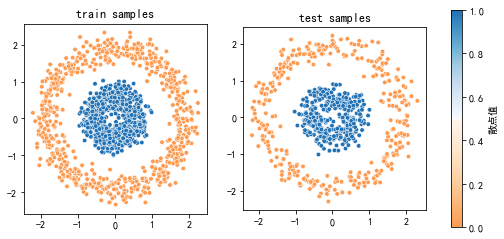

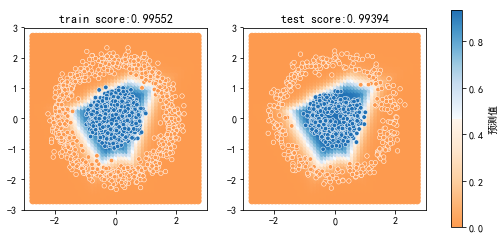

In [7]:
# 自定义颜色映射图
top = cm.get_cmap('Oranges_r', 512)
bottom = cm.get_cmap('Blues', 512)
newcolors = np.vstack((top(np.linspace(0.55, 1, 512)),
                       bottom(np.linspace(0, 0.75, 512))))
cm_bright = ListedColormap(newcolors, name='OrangeBlue')
# 展示训练和测试数据
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(9, 4),subplot_kw = {'aspect':'equal'})
m1 = ax1.scatter(*X.T,c = y,cmap = cm_bright,edgecolors='white',s = 20,linewidths = 0.5)
ax1.set_title('train samples')
m2 = ax2.scatter(*X_test.T,c = y_test,cmap = cm_bright,edgecolors='white',s = 20,linewidths = 0.5)
ax2.set_title('test samples')
plt.colorbar(m1,ax = [ax1,ax2], label='散点值')
plt.show()

# 展示在visual_epoch轮训练得到的预测结果
prob = np.squeeze(net.predict_pro(p))
p1 = np.array([np.squeeze(pp) for pp in p])
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(9, 4),subplot_kw = {'aspect':'equal'})
ax1.scatter(*p1.T,c = prob,cmap = cm_bright)
ax1.scatter(*X.T,c = y,cmap = cm_bright,edgecolors='white',s = 20,linewidths = 0.5)
ax1.set_title('train score:%.5f'%net.accuracy(training_data,convert=True))
mp = ax2.scatter(*p1.T,c = prob,cmap = cm_bright)
ax2.scatter(*X_test.T,c = y_test,cmap = cm_bright,edgecolors='white',s = 20,linewidths = 0.5)
ax2.set_title('test score:%.5f'%net.accuracy(test_data,convert=True))
plt.colorbar(mp,ax = [ax1,ax2],label='预测值')
plt.show()

加载并可视化指定训练轮数之后的训练样本和测试样本损失值：

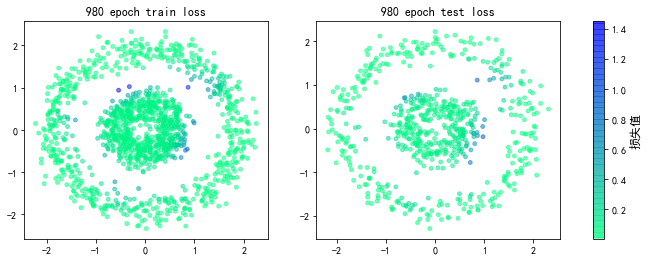

In [8]:
%matplotlib inline
train_loss = np.load("log/train_loss.npy")
test_loss = np.load("log/test_loss.npy")
min_train,max_train = train_loss[visualize_epoch,:].min(),train_loss[visualize_epoch,:].max()
min_test,max_test = test_loss[visualize_epoch,:].min(),test_loss[visualize_epoch,:].max()
min_all,max_all = np.min([min_train,min_test]),np.max([max_test,max_train])
norm = colors.Normalize(vmin=min_all,vmax=max_all)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
scat = ax1.scatter(*X.T,c=train_loss[visualize_epoch,:],cmap='winter_r',norm=norm,alpha=0.5,s=15)
ax2.scatter(*X_test.T,c=test_loss[visualize_epoch,:],cmap = 'winter_r',norm=norm,alpha=0.5,s=15)
cbar = fig.colorbar(scat,ax=(ax1,ax2),)
ax1.set_title('%d epoch train loss'% visualize_epoch)
ax2.set_title('%d epoch test loss' % visualize_epoch)
cbar.set_label('损失值',fontsize=12)

绘制损失值和正确分类概率之间的对应曲线，其中标记点对应损失最高点和损失最低点：

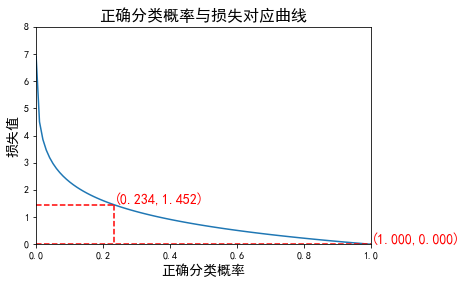

In [9]:
loss_x = np.linspace(0.001,0.999,100)
loss_y = -np.log(loss_x)
max_x = np.exp(-max_all)
min_x = np.exp(-min_all)
plt.plot(loss_x,loss_y)
plt.plot((0.001,min_x),(min_all,min_all),'r--')
plt.plot((0.001,max_x),(max_all,max_all),'r--')
plt.plot((min_x,min_x),(min_all,0),'r--')
plt.plot((max_x,max_x),(max_all,0),'r--')
plt.annotate('(%.3f,%.3f)'%(min_x,min_all),xy=(min_x,min_all),fontsize=14,color='r')
plt.annotate('(%.3f,%.3f)'%(max_x,max_all),xy=(max_x,max_all),fontsize=14,color='r')
plt.xlim(0,1)
plt.ylim(0,8)
plt.xlabel("正确分类概率",fontsize=14)
plt.ylabel("损失值",fontsize=14)
plt.title("正确分类概率与损失对应曲线",fontsize=16)
plt.show()

## 7.7.3 定义可视化方法和相关设置

In [159]:
# 定义绘图和编码映射的相关函数方法
def scatter(p, c, X, y, wb=None, cmap=['coolwarm','RdGy'], 
            value=False, zero_start=False,norm=True,title=['胞腔划分','散点值'],
            norm1=None,ticks1=[0,1],cbar_fontsize=14,s=20,draw_point=True,
           draw_axis_label=False,draw_bg=True,sysmetrical=False):
    """value:是否为连续值；zero_start：是否从0开始;norm:是否规定第一个颜色棒的映射范围,title：两个colorbar的标题，
    norm1：规定第二个颜色棒的映射范围;draw_axis_label:是否绘制坐标轴标签；draw_bg:是否绘制特征空间北京"""
    cols = p.shape[-1]
    assert cols in (1,2,3)
    if draw_bg:
        fig = plt.figure(figsize=(8, 4))
    else:
        fig = plt.figure(figsize=(6, 4))
    c_u = np.unique(c)
    x_u= np.unique(y)
    if sysmetrical:
        abs_max_x = round(np.max(np.abs(y)),1)
        norm_sysmetrical=colors.Normalize(vmin=-abs_max_x,vmax=abs_max_x)
    if norm is not None:
        norm = colors.Normalize(vmax=1,vmin=0)
    if norm1 is not None:
        ticks1=ticks1
    if cols == 3:
        ax3d = Axes3D(fig)
        if wb is not None:
            a1, a2 = p.min(0)[:2]
            b1, b2 = p.max(0)[:2]
            a, b = np.mgrid[a1 - 1:b1:10j, a2 - 1:b2:10j]
            (u1, u2, u3), b_ = wb
            z_ = (a * u1 + b * u2 + b_) / (-u3)
            wf = ax3d.plot_wireframe(a, b, z_)
        if draw_bg:
            mp2 = ax3d.scatter(*p.T, c=c, cmap=cmap[0], norm = norm,s=s)
            if value:
                cbar2 = fig.colorbar(mp2, shrink=0.8)  
            else:
                if zero_start:
                    cbar2 = fig.colorbar(mp2, shrink=0.8, ticks=np.linspace(0, c_u.shape[0] - 1, c_u.shape[0]))
                else:
                    cbar2 = fig.colorbar(mp2, ticks=c_u,shrink=0.8)
            cbar2.set_label(title[0],fontsize = cbar_fontsize)
        
            
        mp1 = ax3d.scatter(*X.T, c=y, cmap=cmap[1], edgecolors='white', s=40, linewidths=0.5,norm=norm1)
        if norm1 is not None:
            cbar1 = fig.colorbar(mp1, shrink=0.8,ticks=ticks1)
        else:
            cbar1 = fig.colorbar(mp1, shrink=0.8)
        
        if draw_axis_label:
            ax3d.set_xlabel('X')
            ax3d.set_ylabel('Y')
            ax3d.set_zlabel('Z')
        cbar1.set_label(title[1],fontsize=cbar_fontsize)

        return ax3d
    
    elif cols == 2:
        ax = plt.gca()
#         ax.axis('equal')
        if wb is not None:
            a1, a2 = p.min(0) - 0.2
            b1, b2 = p.max(0) + 0.2
            (u1, u2), b_ = wb
            y1, y2 = (a1 * u1 + b_) / (-u2), (b1 * u1 + b_) / (-u2)
            ax.plot([a1, b1], [y1, y2], 'r--')
            ax.set_ylim(a2, b2)
        if draw_bg:
            st = ax.scatter(*p.T, c=c, cmap=cmap[0],norm = norm)
            if value:
                cbar2 = fig.colorbar(st,shrink=0.8)
            else:
                if zero_start:
                    cbar2 = fig.colorbar(st, ticks=np.linspace(0, c_u.shape[0] - 1, c_u.shape[0]),shrink=0.8)
                else:
                    cbar2 = fig.colorbar(st, ticks=c_u,shrink=0.8)
            cbar2.set_label(title[0],fontsize = cbar_fontsize)
        if draw_point:
            if sysmetrical:
                st1=ax.scatter(*X.T, c=y, alpha=0.7, cmap=cmap[1], edgecolors='white', s=s, linewidths=0.5,norm=norm_sysmetrical)
            else:
                st1=ax.scatter(*X.T, c=y, alpha=0.7, cmap=cmap[1], edgecolors='white', s=s, linewidths=0.5,norm=norm1)
            if norm1 is not None:
                cbar1 = fig.colorbar(st1, shrink=0.8,ticks=ticks1)
            else:
                cbar1 = fig.colorbar(st1, shrink=0.8)
            cbar1.set_label(title[1],fontsize=cbar_fontsize)
        
        if draw_axis_label:
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
        
        
    else:
        ax = plt.gca()
        t, tt = np.zeros_like(p.flat), np.zeros_like(X.flat)
        if draw_bg:
            st = ax.scatter(p.flat,t,c=c,cmap=cmap[0],norm=norm)
            if value:
                cbar2 = fig.colorbar(st,shrink=0.8)
            else:
                if zero_start:
                    cbar2 = fig.colorbar(st, ticks=np.linspace(0, c_u.shape[0] - 1, c_u.shape[0]),shrink=0.8)
                else:
                    cbar2 = fig.colorbar(st, ticks=c_u,shrink=0.8)
            cbar2.set_label(title[0],fontsize = cbar_fontsize)
        st1 = ax.scatter(X.flat, tt, c=y, alpha=0.7, cmap=cmap[1], edgecolors='white', s=s, linewidths=0.5,norm=norm1)
        if norm1 is not None:
            cbar1 = fig.colorbar(st1, shrink=0.8,ticks=ticks1)
        else:
            cbar1 = fig.colorbar(st1, shrink=0.8)
        
        cbar1.set_label(title[1],fontsize=cbar_fontsize)
    return ax
    
def mapping(code):
    # 将编码转化为01编码的类型
    numMap = np.zeros(code.shape[0])
    uniq = np.unique(code, axis=0)
    for i, arr in enumerate(uniq):
        m = (np.sum(code == arr, axis=1) == code.shape[-1])
        numMap[m] = i
    return numMap

重新定义一个用来显示胞腔的颜色序列：

In [11]:
color_list = ['aquamarine', 'b', 'blueviolet','c', 'chartreuse',
 'darkcyan', 'darkgreen', 'darkkhaki', 'deeppink', 'deepskyblue',
 'gold', 'indigo', 'lightcoral', 'maroon', 'navy', 'olivedrab', 'peru',
 'pink', 'rosybrown', 'saddlebrown', 'slategray', 'steelblue', 'teal',
 'thistle', 'violet', 'y', 'yellow']
cmap = colors.ListedColormap(color_list)

## 7.7.4 反向传播过程可视化

加载反向传播过程中的各种参数:

In [12]:
delta_log = np.load("log/delta_log.npy", allow_pickle=True)
Pl_Pa_log = np.load("log/Pl_Pa.npy",allow_pickle=True)
w_grad_log = np.load("log/w_grad_log.npy",allow_pickle=True)

可视化误差的反向传播过程以及参数的更新过程。

**全连接层：**  
    *a. 反向传播过程:*  
        (1) 传递到第$l$层参与反向传播计算的$\frac{\partial J}{\partial a^l}$，背景为第层胞腔划分    
        (2) $\sigma^\prime(z^l) = \frac{\partial a^l}{\partial z^l}$，背景为本层胞腔划分    
        (3) $\delta^l = \frac{\partial J}{\partial z^l}$，背景为本层胞腔划分    
    *b. 参数更新贡献示意: 1代表参数值增大会使损失下降，0代表参数值变化对损失无影响，-1代表参数值减小会使损失下降*    
        (1) $\delta^l$的贡献，背景为前$l$层累积胞腔划分（包括当前层）    
        (2) 输入值$X^l$的贡献，背景为第$l-1$层胞腔划分（前一层）    
        (3) 权值$w$的更新方向，背景为第$l-1$层胞腔划分（前一层） 
        
**卷积层与池化层：**两者绑定为一个层，以下代码只针对卷积层输入特征维度为3，一维卷积核大小为2，步长为1，padding为valid,池化为最大池化。因此一个卷积特征图中包含两个卷积节点。  
    *a. 反向传播过程:*    
        (1) 池化后$\delta$，背景为池化后该节点在原始特征空间的胞腔划分    
        (2) 最大池化中最大值对应的特征图位置    
        (3) 卷积节点的$\frac{\partial J}{\partial a^l}$，无背景    
        (4) 卷积节点的$\sigma^\prime(z^l) = \frac{\partial a^l}{\partial z^l}$，背景为该卷积节点的胞腔划分    
        (5) 卷积节点的$\delta^l = \frac{\partial J}{\partial z^l}$，背景为该卷积节点的胞腔划分    
    *b. 参数更新贡献示意:1代表参数值增大会使损失下降，0代表参数值变化对损失无影响，-1代表参数值减小会使损失下降*    
        (1) 输入值$X^l$的贡献，背景为第$l-1$层胞腔划分（前一层）    
        (2) 卷积节点的$\delta$贡献，背景为池化层胞腔划分    
        (3) 各卷积节点导致的权值$w$的更新方向，背景为前$l$层累积胞腔划分       

由于图片输出顺序为正向传播顺序，因此反向传播应**倒序**查看。图片右侧的第一个颜色棒为特征空间值，第二个颜色棒为散点值。

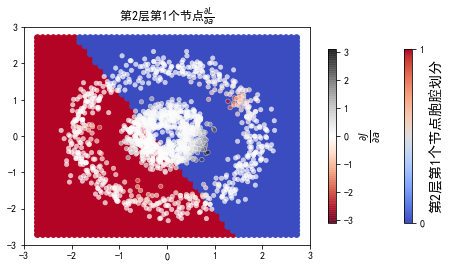

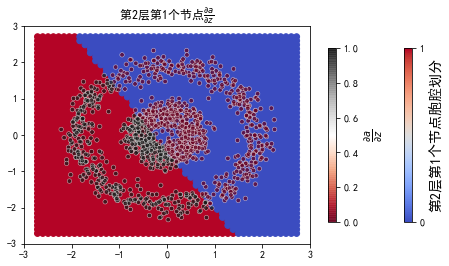

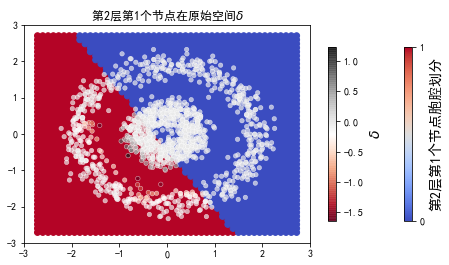

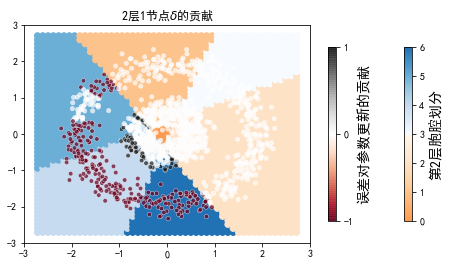

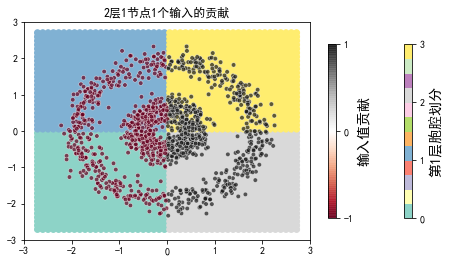

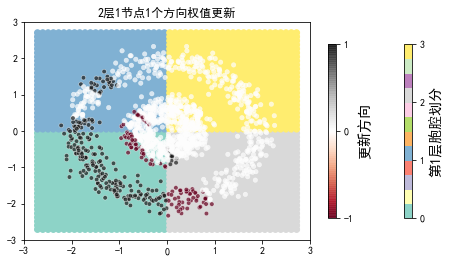

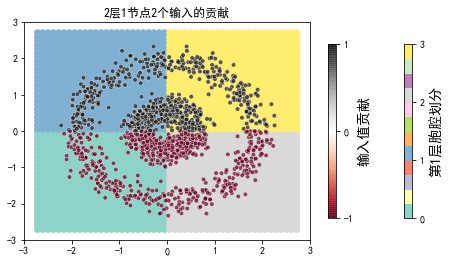

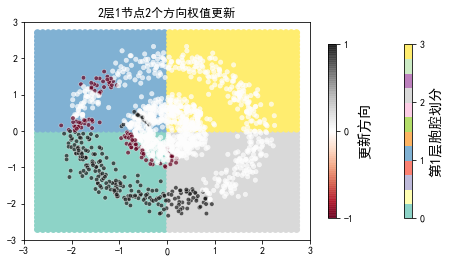

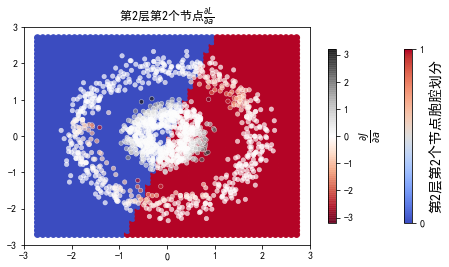

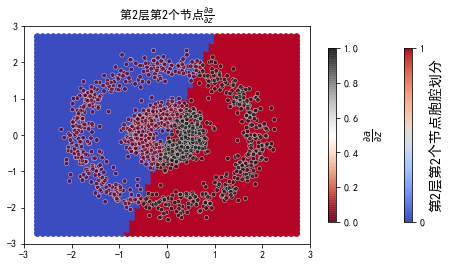

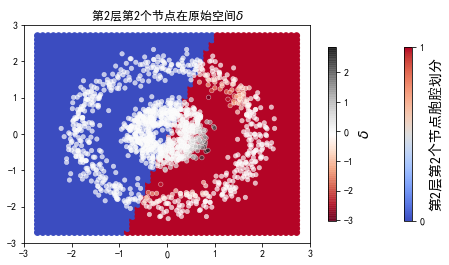

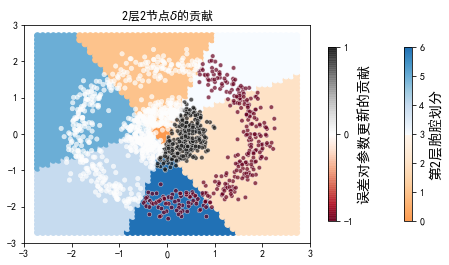

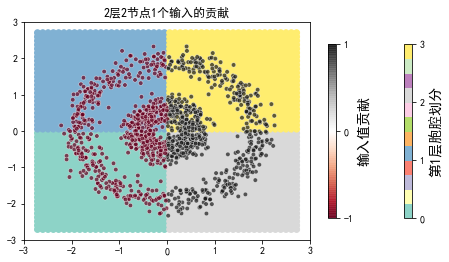

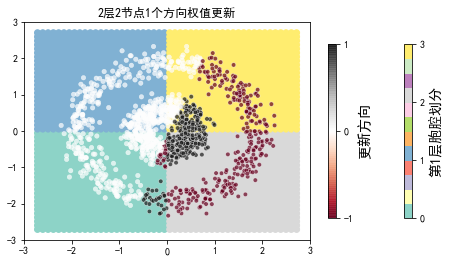

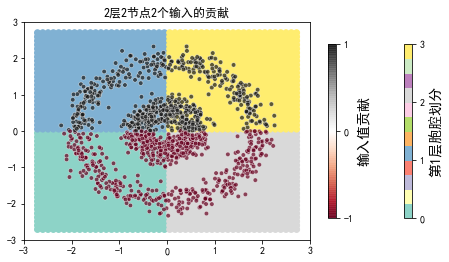

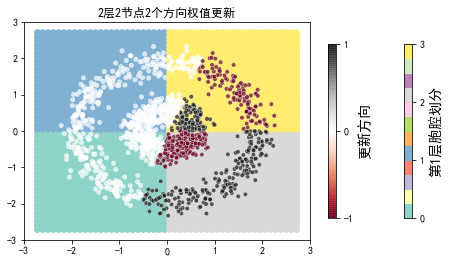

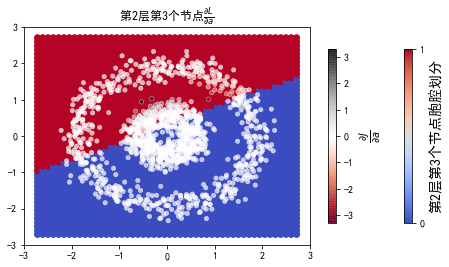

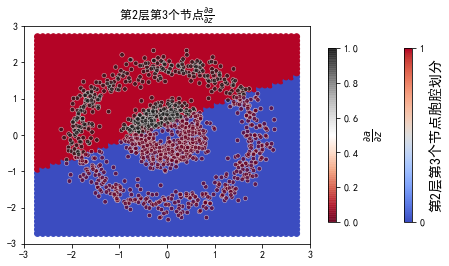

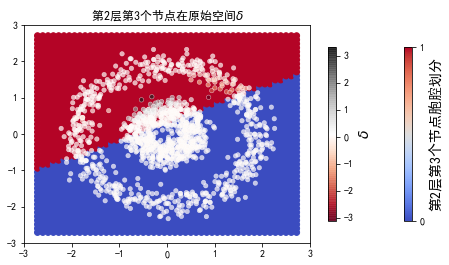

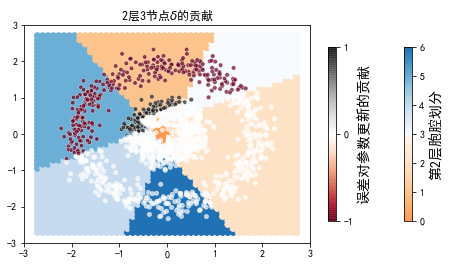

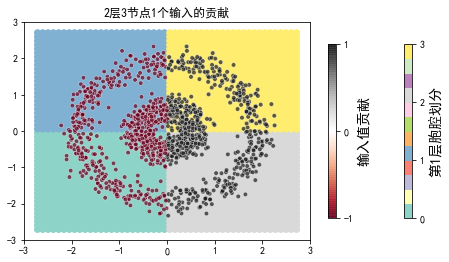

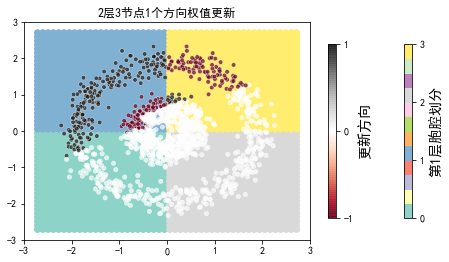

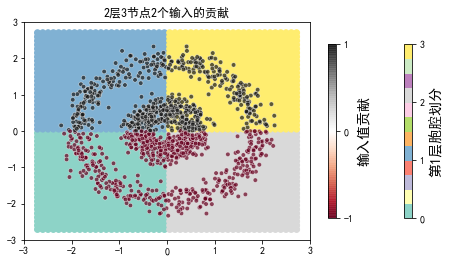

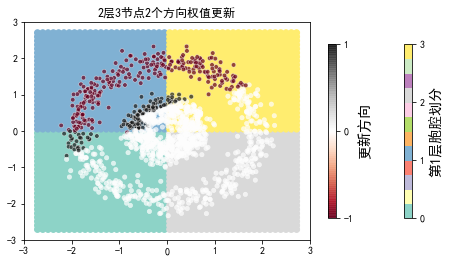

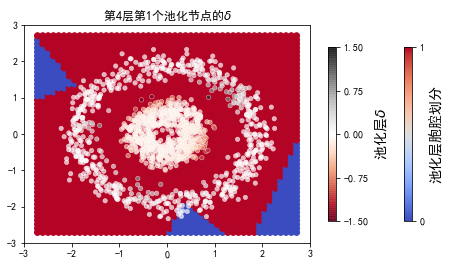

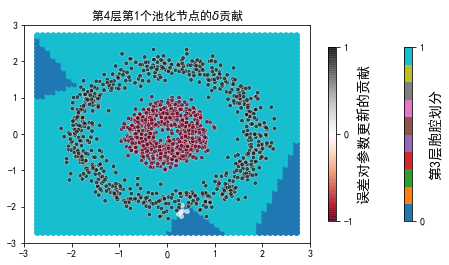

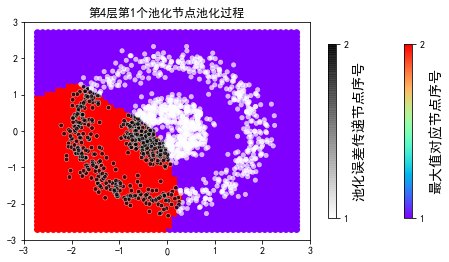

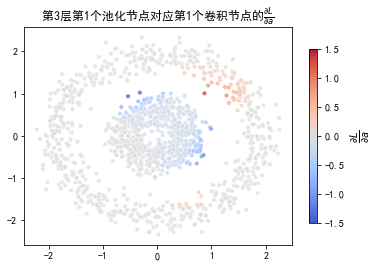

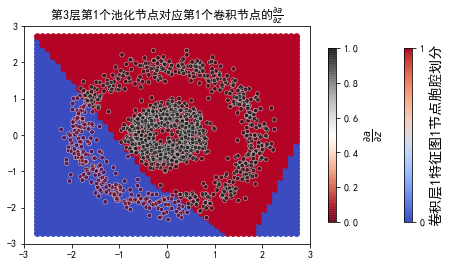

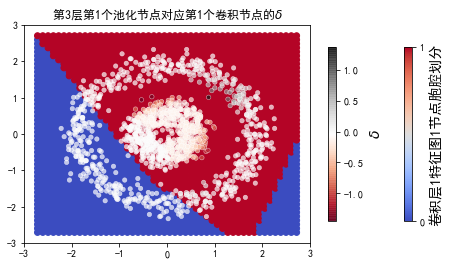

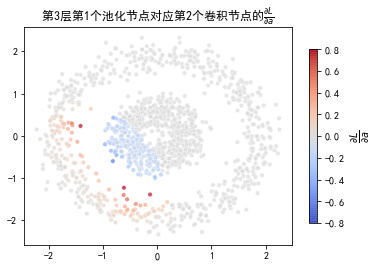

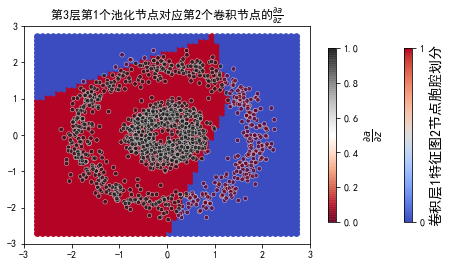

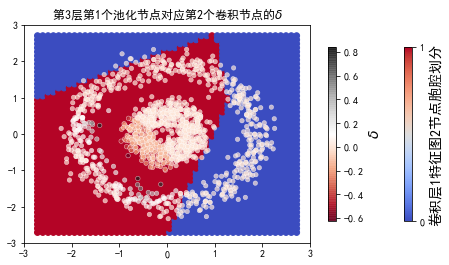

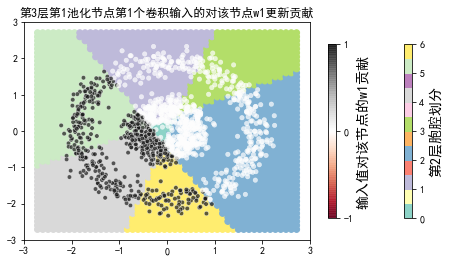

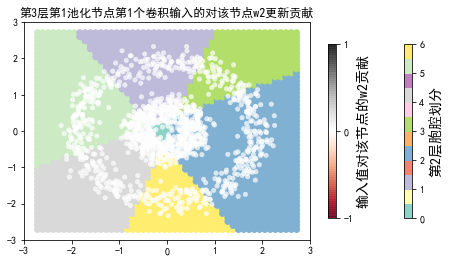

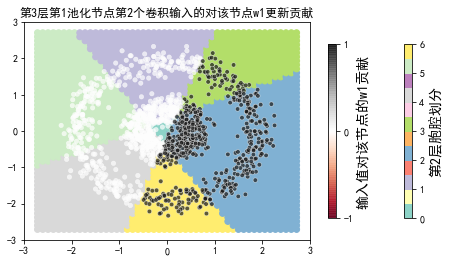

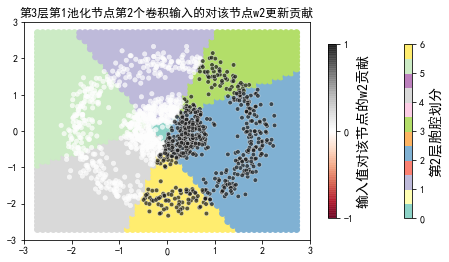

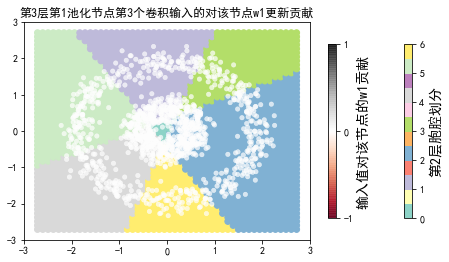

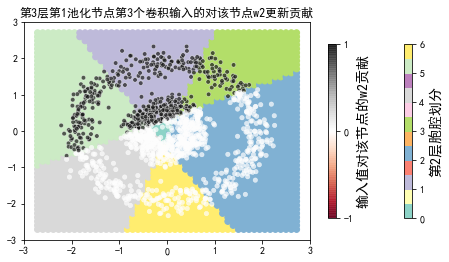

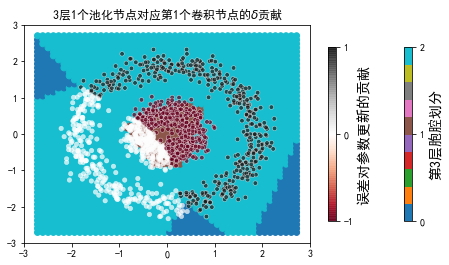

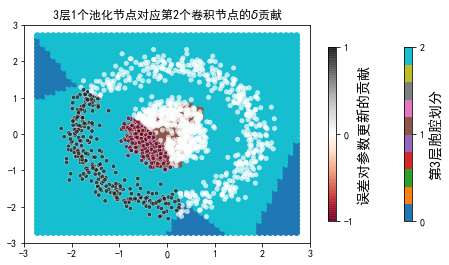

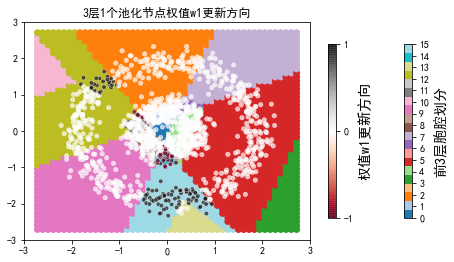

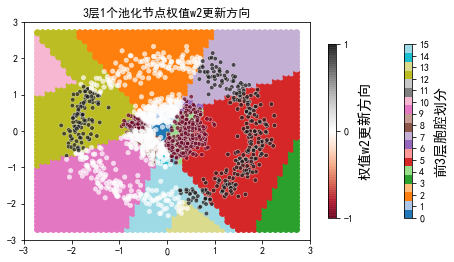

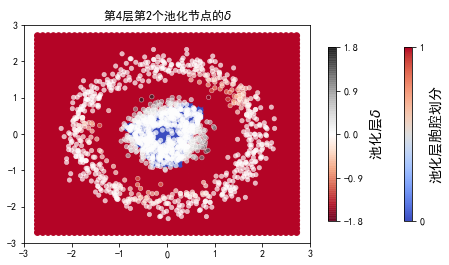

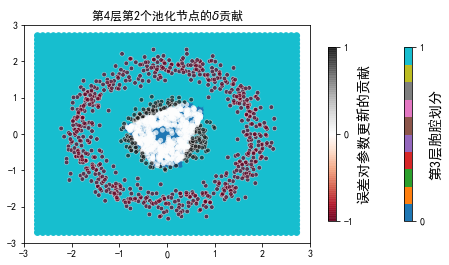

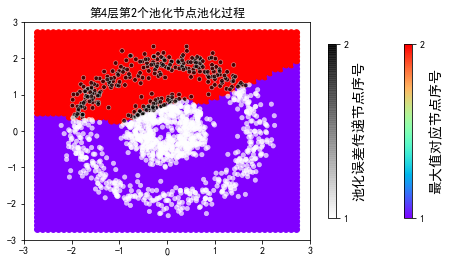

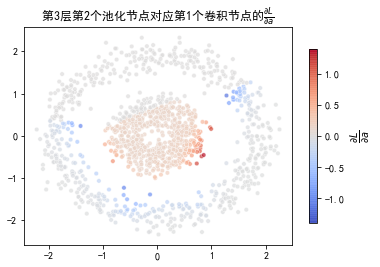

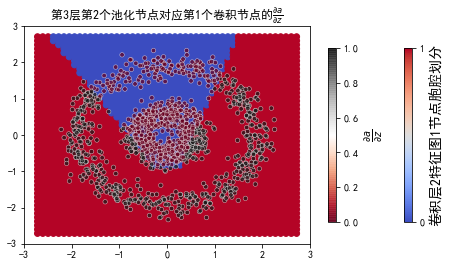

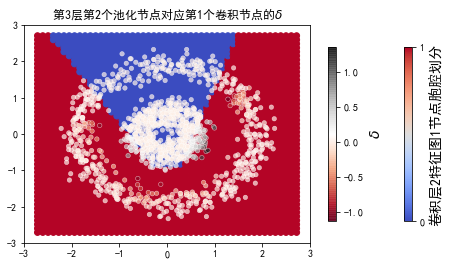

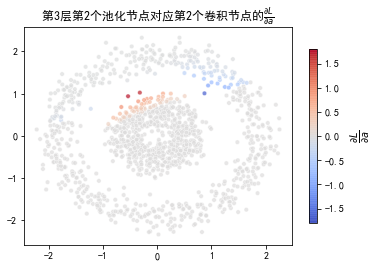

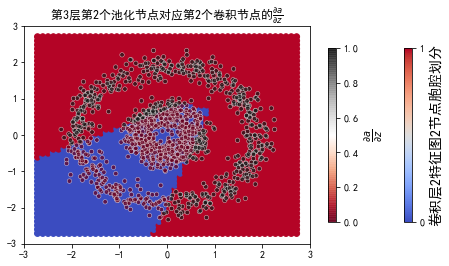

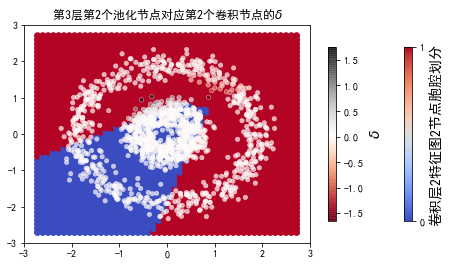

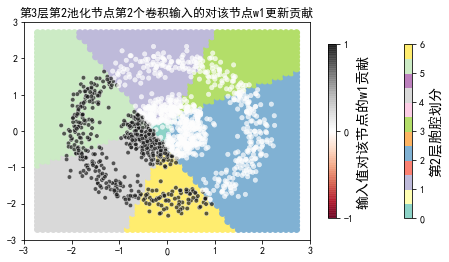

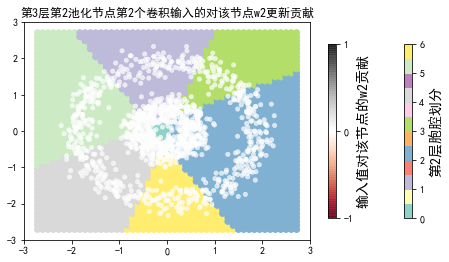

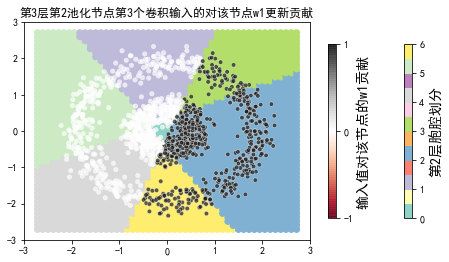

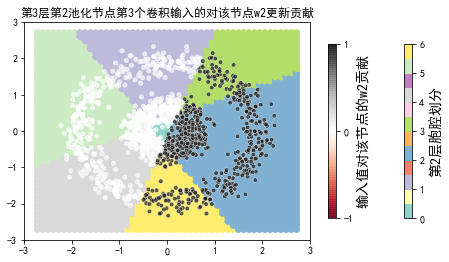

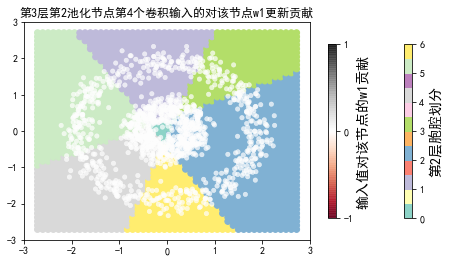

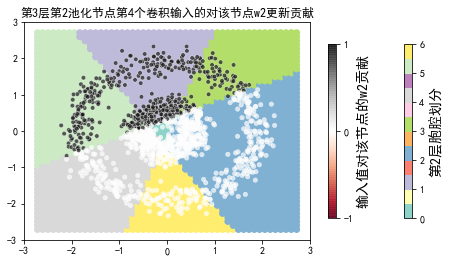

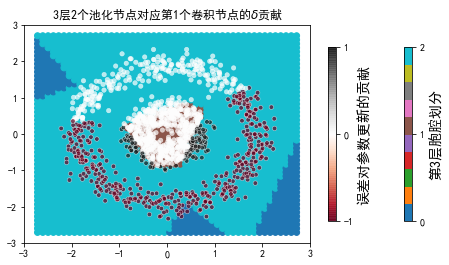

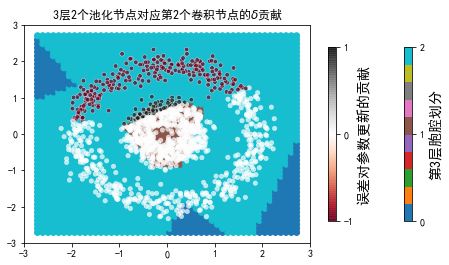

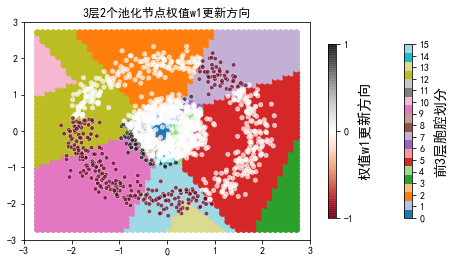

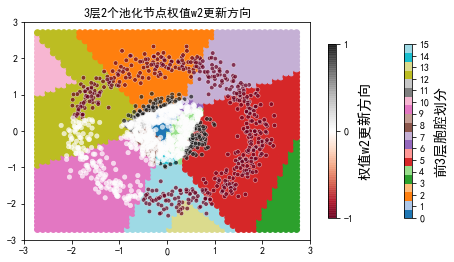

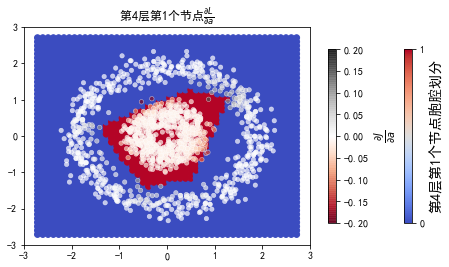

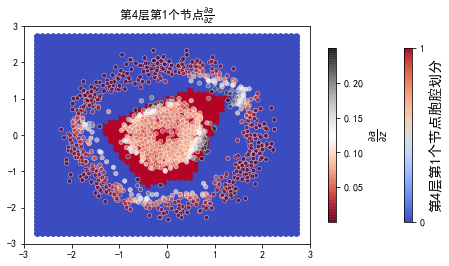

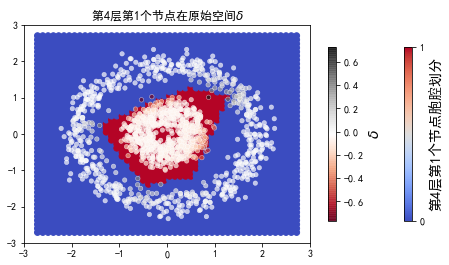

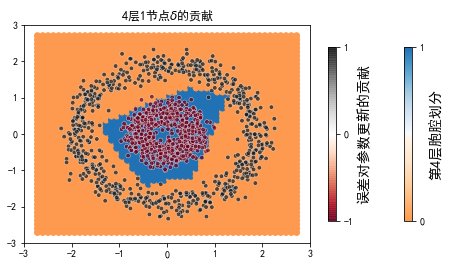

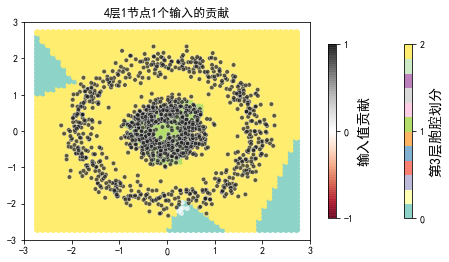

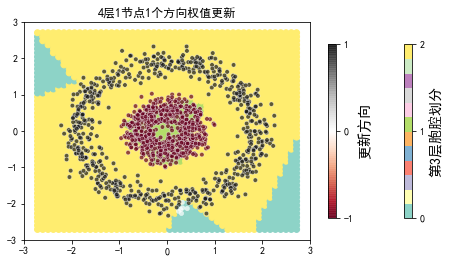

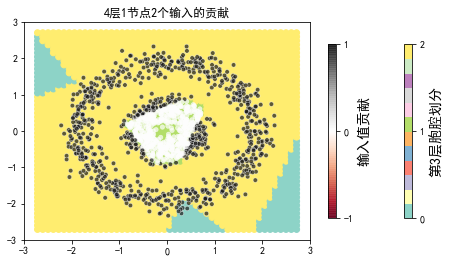

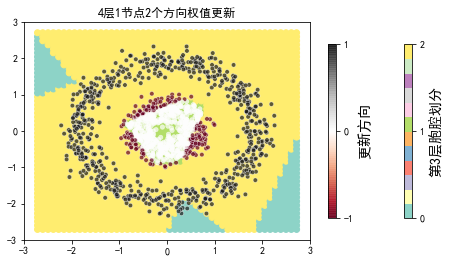

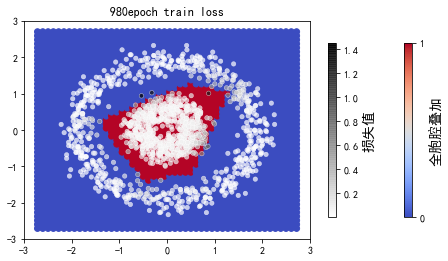

In [183]:
W,B = net.weights, net.biases
W,B = [w.T for w in W],[b.squeeze(axis=1) for b in B]
delta = delta_log[visualize_epoch]
Pl_Pa = Pl_Pa_log[visualize_epoch]
inV,inX,inX_t = p_0,X,X_test
layersBinCode = None
X_layersBinCode = None
l_num = 0 # 层序号
layer_num = len(W) # 总层数
layersNumCodes = [] # 胞腔编码序号
layersBinCodes = [] # 累计胞腔划分01编码

for layer,(w, b) in enumerate(zip(W, B)):
    delta_L = np.squeeze([d[l_num] for d in delta])
    Pl_Pa_L = np.squeeze([p[-l_num-1] for p in Pl_Pa])
#     delta_L_pool = np.squeeze([d[l_num-1] for d in delta])
    delta_L_pool = np.squeeze([d[l_num] for d in delta])
    if len(delta_L.shape)<2:
        delta_L = np.expand_dims(delta_L,1)
    if len(Pl_Pa_L.shape)<2:
        Pl_Pa_L = np.expand_dims(Pl_Pa_L,1)
    l_num =layer+1
    if l_num < len(W):
            activation = 'relu'
            actf = net.activation_fn.fn
            actf_P = net.activation_fn.prime
    else:
            activation = 'sigmoid'
            actf = network.sigmoid_activation.fn
            actf_P = network.sigmoid_activation.prime
    if net.layers_type[layer]=='D':
        transV = inV @ w + b
        transX = inX @ w + b
        actV = actf(transV)
        actX = actf(transX)
        primeX = actf_P(transX)

        # 第k层各个节点的划分(第k层的二进制编码)
        if activation == 'relu':
            layerBinCode = np.where(actV > 0, 1, 0)
        elif activation == 'sigmoid':
            layerBinCode = np.where(actV > 0.5, 1, 0)
        elif activation == 'tanh':
            layerBinCode = np.where(actV > 0, 1, 0)
    else:
        if layer>0:
            layerBinCode0=layerBinCode
            primeX0=primeX
        conv_size = net.sizes[layer+1]
        activation='relu'
        actf = net.activation_fn.fn
        transV_ = np.zeros((inV.shape[0],conv_size[0],conv_size[1]))
        transX_ = np.zeros((inX.shape[0],conv_size[0],conv_size[1]))
        for c_num in range(inV.shape[1]-conv_size[1]+1):
            transV_[:,:,c_num]=inV[:,c_num:c_num+conv_size[1]].reshape(-1,conv_size[1])@w+b
            transX_[:,:,c_num]=inX[:,c_num:c_num+conv_size[1]].reshape(-1,conv_size[1])@w+b
        actV_ = actf(transV_)
        actX_ = actf(transX_)
        actX_max_pooling = np.max(actX_,axis=2)
        actV_max_pooling = np.max(actV_,axis=2)
        actX_max_ind = np.argmax(actX_,axis=2)
        actV_max_ind = np.argmax(actV_,axis=2)
        # 针对池化层
        insert_0 = np.zeros_like(actV_)
        insert_0[:,0,0] = 1-actV_max_ind[:,0]
        insert_0[:,0,1] = actV_max_ind[:,0]
        insert_0[:,1,0] = 1-actV_max_ind[:,1]
        insert_0[:,1,1] = actV_max_ind[:,1]
        # 第k层各个节点的划分(第k层的二进制编码)
        if activation == 'relu':
            layerBinCode_pool_before = np.where(transV_>0,1,0)
            layerBinCode = (insert_0*layerBinCode_pool_before).sum(axis=-1)
            assert layerBinCode.max()<=1
        elif activation == 'sigmoid':
            layerBinCode_pool_before = np.where(transV_>0.5,1,0)
            layerBinCode = (insert_0*layerBinCode_pool_before).sum(axis=-1)
            assert layerBinCodel.max()<=1
        elif activation == 'tanh':
            layerBinCode_pool_before = np.where(transV_>0,1,0)
            layerBinCode = (insert_0*layerBinCode_pool_before).sum(axis=-1)
            assert layerBinCode.max()<=1
        else:
            raise ValueError
        actX = actX_max_pooling
        actV = actV_max_pooling
        transX = np.squeeze([t_x[list(range(transX_.shape[1])),a_i] for t_x,a_i in zip(transX_,actX_max_ind)])
        transV = np.squeeze([t_v[list(range(transV_.shape[1])),a_i] for t_v,a_i in zip(transV_,actV_max_ind)])
        primeX = actf_P(transX)
        primeX_ = actf_P(transX_)
        
    # 保存前一层的胞腔划分
    if layer==0:
        if activation=='relu':
            layerBinCode0 = np.where(inV>0,1,0)
            layerNumCode0 = mapping(layerBinCode0)
        elif activation=='sigmoid':
            layerBinCode0=np.where(inV>0.5,1,0)
            layerNumCode0 = mapping(layerBinCode0)
        elif activation=='tanh':
            layerBinCode0 = np.where(inV>0,1,0)
            layerNumCode0 = mapping(layerBinCode0)
        else:
            raise ValueError
    else:
        layerNumCode0 = layerNumCode
        
    layerNumCode = mapping(layerBinCode)
    # 第k层的激活神经元的数量
    layerNumCode2 = np.sum(layerBinCode, 1)

    # 前k层的二进制编码
    layersBinCode = layerBinCode if layersBinCode is None else np.hstack((layersBinCode, layerBinCode))
    # 前k层的数字编码
    layersNumCode = mapping(layersBinCode)
    # 前k层激活神经元的数量
    layersNumCode2 = np.sum(layersBinCode, 1)
    
    n = actV.shape[-1]
    n_in = inV.shape[-1]
    
    l = np.vstack((w, b)).T.astype('<U5').tolist()
    sl = [';'.join(z) for z in l]
    projIn = '3d' if inV.shape[-1] == 3 else None
    projOut = '3d' if transV.shape[-1] == 3 else None
    
    for i in range(n):        
        """各层对权值更新的贡献"""
        norm1= colors.Normalize(vmax=1,vmin=-1)
        norm2= colors.Normalize(vmax=1,vmin=0)
        norm3 = colors.Normalize(vmax=2,vmin=1)
        if net.layers_type[layer]=='D':
#             continue
            """绘制反向传播过程"""
            #原始特征空间的偏l/偏a
            ax = scatter(p_0,layerBinCode.T[i], X, Pl_Pa_L[:,i],
                         title=['第%d层第%d个节点胞腔划分'%(l_num+1,i+1),
                                r'$ \frac{\partial J}{\partial a} $'],sysmetrical=True)
            ax.set_title(r'第%d层第%d个节点$ \frac{\partial L}{\partial a} $' % (l_num+1,i+1))
            # 原始特征空间的偏a/偏z本层
            ax = scatter(p_0,layerBinCode.T[i], X, primeX[:,i],
                         title=['第%d层第%d个节点胞腔划分'%(l_num+1,i+1),
                                r'$ \frac{\partial a}{\partial z} $'])
            ax.set_title(r'第%d层第%d个节点$ \frac{\partial a}{\partial z} $' % (l_num+1,i+1))
            #原始特征空间的误差与节点划分
            ax = scatter(p_0, layerBinCode.T[i], X, delta_L[:,i],
                         title=['第%d层第%d个节点胞腔划分'%(l_num+1,i+1),r'$ \delta $'])
            ax.set_title('第%d层第%d个节点在原始空间$ \delta $' % (l_num+1,i+1))
            
#             continue
            
            """绘制更新贡献"""
            contrib_code1 = np.where(delta_L[:,i] > 0,1,0) 
            contrib_code2 = np.where(delta_L[:,i] < 0,-1,0)
            """delta_contrib_code标志误差对参数变化的影响，1代表使参数值正向增加，0代表不对参数值更新有贡献，-1代表使参数值反向增加"""
            delta_contrib_code = contrib_code1 + contrib_code2 
            ax = scatter(p_0,layerNumCode,X,delta_contrib_code,cmap=[cm_bright,'RdGy'],
                         value=False,zero_start=False,norm=None,norm1=norm1,
                     ticks1=[-1,0,1],
                     title=['第%d层胞腔划分'%(l_num+1),'误差对参数更新的贡献'])
            ax.set_title(r'%d层%d节点$\delta$的贡献'%(l_num+1,i+1))
            for nn in range(inX.shape[1]):
                contrib_code1 = np.where(inX[:,nn]>0,1,0)
                contrib_code2 = np.where(inX[:,nn]<0,-1,0)
                inX_contrib_code = contrib_code1+contrib_code2
                ax = scatter(p_0,layerNumCode0,X,inX_contrib_code,cmap=['Set3','RdGy'],
                             value=False,zero_start=False,
                             norm=None,norm1=norm1,
                             ticks1=[-1,0,1],title=['第%d层胞腔划分'%(l_num),'输入值贡献'])
                ax.set_title('%d层%d节点%d个输入的贡献'%(l_num+1,i+1,nn+1))
                ax = scatter(p_0,layerNumCode0,X,delta_contrib_code*inX_contrib_code,cmap=['Set3','RdGy'],
                             value=False,zero_start=False,
                            norm=None,norm1=norm1,
                            ticks1=[-1,0,1],title=['第%d层胞腔划分'%(l_num),'更新方向'])
                ax.set_title('%d层%d节点%d个方向权值更新'%(l_num+1,i+1,nn+1))
        elif net.layers_type[layer]=='C':
            """反向传播到卷积池化层的delta，只针对池化特征数为2成立"""
            pool_layer_delta = np.zeros((len(delta_L),2))
            pool_layer_delta[:,0]=delta_L[:,i].copy()
            pool_layer_delta[:,1]=delta_L[:,i].copy()
            pool_layer_Pl_Pa = np.zeros((len(Pl_Pa_L),2))
            pool_layer_Pl_Pa[:,0] = Pl_Pa_L[:,i].copy()
            pool_layer_Pl_Pa[:,1] = Pl_Pa_L[:,i].copy()
            delta_inzert_0 = np.zeros_like(pool_layer_delta)
            delta_inzert_0[:,1]=actX_max_ind[:,i]
            delta_inzert_0[:,0]=1-actX_max_ind[:,i]
            pool_layer_delta=pool_layer_delta*delta_inzert_0
            pool_layer_Pl_Pa = pool_layer_Pl_Pa*delta_inzert_0
            """反向传播过程"""
            n_pool = actV_.shape[-1]
            abs_max_pool = round(np.max(np.abs(delta_L_pool[:,i])),1)
            norm_pool = colors.Normalize(vmin=-abs_max_pool,
                                         vmax=abs_max_pool)
            tick_pool = np.linspace(-abs_max_pool,abs_max_pool,5)
            delta_L_pool_contrib = np.where(delta_L_pool[:,i]>0,1,0)+np.where(delta_L_pool[:,i]<0,-1,0)
            ax = scatter(p_0,layerBinCode[:,i],X,delta_L_pool[:,i],norm1=norm_pool,ticks1=tick_pool,
                         draw_bg=True,
                         title=['池化层胞腔划分',r'池化层$\delta$'])
            ax.set_title(r'第%d层第%d个池化节点的$ \delta $' % (l_num+2,i+1))
            ax = scatter(p_0,layerBinCode[:,i],X,delta_L_pool_contrib,
                             cmap=['tab10','RdGy'],value=False,zero_start=False,
                             norm=None,norm1=norm1,
                     ticks1=[-1,0,1],
                     title=['第%d层胞腔划分'%(l_num+1),'误差对参数更新的贡献'])
            ax.set_title(r'第%d层第%d个池化节点的$ \delta $贡献' % (l_num+2,i+1))
            ax = scatter(p_0,actV_max_ind[:,i]+1,X,delta_inzert_0[:,1]+1,
                         title=['最大值对应节点序号','池化误差传递节点序号'],
                         cmap=['rainbow','binary'],norm=None,value=False,zero_start=False,
                         ticks1=[1,2],norm1=norm3)
            ax.set_title('第%d层第%d个池化节点池化过程' % (l_num+2,i+1)) 
            """此处只针对写死的结构"""
            w_conv=np.array([np.append(w[:,i],0),np.append(0,w[:,i])])
            for i_n in range(n_in):
                continue
                print(w[:,i])
                pl_pa_conv = pool_layer_delta*primeX0[:,i_n,None]
                par_delta_conv1 = pl_pa_conv[:,0,None]@ w_conv[0,:][None]
                par_delta_conv2 = pl_pa_conv[:,1,None]@ w_conv[1,:][None]
                par_delta_conv = par_delta_conv1+par_delta_conv2
                ax = scatter(p_0,layerBinCode0.T[i_n], X, 
                             primeX0[:,i_n],
                             title=['卷积层%d特征图%d节点胞腔划分'%(i+1,1),
                                    r'$ \frac{\partial a}{\partial z} $方向'])
                ax = scatter(p_0,layerBinCode0.T[i_n], X, 
                             par_delta_conv[:,i_n],
                             title=['卷积层%d特征图%d节点胞腔划分'%(i+1,2),
                                    r'$ \delta $方向'],sysmetrical=True)
  
            for po in range(n_pool):
                """绘制反向传播过程"""
                #原始特征空间的偏l/偏a
                ax = scatter(p_0,layerBinCode_pool_before[:,i,:].T[po], X, 
                             pool_layer_Pl_Pa[:,po],
                             cmap=['coolwarm','coolwarm'],draw_bg=False,
                             title=['卷积层%d特征图%d节点胞腔划分'%(i+1,po+1),
                                    r'$ \frac{\partial L}{\partial a} $'],sysmetrical=True)
                ax.set_title(r'第%d层第%d个池化节点对应第%d个卷积节点的$ \frac{\partial L}{\partial a} $' % (l_num+1,i+1,po+1))
                # 原始特征空间的偏a/偏z本层
                ax = scatter(p_0,layerBinCode_pool_before[:,i,:].T[po], X, primeX_[:,i,po],
                             title=['卷积层%d特征图%d节点胞腔划分'%(i+1,po+1),
                                    r'$ \frac{\partial a}{\partial z} $'])
                ax.set_title(r'第%d层第%d个池化节点对应第%d个卷积节点的$ \frac{\partial a}{\partial z} $' % (l_num+1,i+1,po+1))
                #原始特征空间的误差与节点划分
                ax = scatter(p_0, layerBinCode_pool_before[:,i,:].T[po], 
                             X, pool_layer_delta[:,po],
                             title=['卷积层%d特征图%d节点胞腔划分'%(i+1,po+1),
                                    r'$ \delta $'])
                ax.set_title(r'第%d层第%d个池化节点对应第%d个卷积节点的$ \delta $' % (l_num+1,i+1,po+1))                
                        
            for nn in range(inX.shape[1]):
                """该循环中的内容仅针对一维卷积卷积核为大小为2，输入层大小为3的情况"""
                contrib_code1 = np.where(inX[:,nn]>0,1,0)
                contrib_code2 = np.where(inX[:,nn]<0,-1,0)
                contrib_code = contrib_code1+contrib_code2
                
                if nn==0:
                    contrib_w1 = np.ones_like(actX_max_ind[:,i])
                    contrib_w2 = np.zeros_like(contrib_w1)
                elif nn==1:
                    contrib_w1 = np.ones_like(actX_max_ind[:,i])
                    contrib_w2 = contrib_w1.copy()
                else:
                    contrib_w2 = np.ones_like(actX_max_ind[:,i])
                    contrib_w1 = np.zeros_like(contrib_w2)
                X_contrib_w1 = contrib_code*contrib_w1
                X_contrib_w2 = contrib_code*contrib_w2
                ax = scatter(p_0,layerNumCode0,X,X_contrib_w1,
                             cmap=['Set3','RdGy'],value=False,zero_start=False,
                             norm=None,norm1=norm1,
                             ticks1=[-1,0,1],title=['第%d层胞腔划分'%(l_num),'输入值对该节点的w1贡献'])
                ax.set_title('第%d层第%d池化节点第%d个卷积输入的对该节点w1更新贡献'%(l_num+1,i+1,i+nn+1))
                ax = scatter(p_0,layerNumCode0,X,X_contrib_w2,cmap=['Set3','RdGy'],
                             value=False,zero_start=False,
                             norm=None,norm1=norm1,
                             ticks1=[-1,0,1],title=['第%d层胞腔划分'%(l_num),
                                                    '输入值对该节点的w2贡献'])
                ax.set_title('第%d层第%d池化节点第%d个卷积输入的对该节点w2更新贡献'%(l_num+1,i+1,i+nn+1))
            
            contrib_code1 = np.where(inX>0,1,0)
            contrib_code2 = np.where(inX<0,-1,0)
            contrib_code = contrib_code1+contrib_code2
            delta_contrib_code1 = np.where(pool_layer_delta > 0,1,0) 
            delta_contrib_code2 = np.where(pool_layer_delta < 0,-1,0)
            delta_contrib_code = delta_contrib_code1 + delta_contrib_code2 
            for po in range(n_pool):
                """delta_contrib_code标志误差对参数变化的影响，
                1代表使参数值正向增加，0代表不对参数值更新有贡献，-1代表使参数值反向增加"""
                ax = scatter(p_0,layerNumCode,X,delta_contrib_code[:,po],
                             cmap=['tab10','RdGy'],value=False,zero_start=False,
                             norm=None,norm1=norm1,
                     ticks1=[-1,0,1],
                     title=['第%d层胞腔划分'%(l_num+1),'误差对参数更新的贡献'])
                ax.set_title(r'%d层%d个池化节点对应第%d个卷积节点的$\delta$贡献'%(l_num+1,i+1,po+1))
                if po==0:
                    w1_contrib = delta_contrib_code[:,po]*contrib_code[:,0]
                    w2_contrib = delta_contrib_code[:,po]*contrib_code[:,1]
                else:
                    w1_contrib = w1_contrib+delta_contrib_code[:,po]*contrib_code[:,1]
                    w2_contrib = w2_contrib+delta_contrib_code[:,po]*contrib_code[:,2]
            ax = scatter(p_0,layersNumCode,X,w1_contrib,
                                 cmap=['tab20','RdGy'],value=False,
                                 zero_start=False,norm=None,norm1=norm1,
                     ticks1=[-1,0,1],
                     title=['前%d层胞腔划分'%(l_num+1),'权值w1更新方向'])
            ax.set_title(r'%d层%d个池化节点权值w1更新方向'%(l_num+1,i+1))
            ax = scatter(p_0,layersNumCode,X,w2_contrib,
                         cmap=['tab20','RdGy'],value=False,
                         zero_start=False,norm=None,norm1=norm1,
                 ticks1=[-1,0,1],
                 title=['前%d层胞腔划分'%(l_num+1),'权值w2更新方向'])
            ax.set_title(r'%d层%d个池化节点权值w2更新方向'%(l_num+1,i+1))

    if l_num <len(W):
        inX = actX
        inV = actV
    plt.show()
ax = scatter(p_0,layerBinCode[:,0],X,train_loss[visualize_epoch,:],cmap=['coolwarm','binary'],norm=None,
             title=['全胞腔叠加','损失值'],s=20)
_ = ax.set_title('%depoch train loss'%(visualize_epoch))